## pyDGSA tutorial (detailed version)

This analytic example consists of 200 model simulations, each of which has 4 parameters and 2 responses. The model parameters are latin hypercube sampled values between 0 and 1:

| v | w | x | y | z |
|------|------|------|------|------|
|0.7975|0.5725|0.5475|0.0675|0.6225|
|0.8175|0.5125|0.3325|0.1325|0.6175|
|0.2075|0.5925|0.7475|0.3625|0.4625|
| .... | .... | .... | .... | .... |

The responses are calculated as:

| Resp. 1 | Resp. 2 | Resp. 3         | Resp. 4 |
|---|---|-----------------|---------|
| z | abs(x * (y - 1)) | sqrt(min(x, y)) | sqrt(z) |

Clearly, `z` should be the most sensitive parameter, followed by `x` and `y`. This is a modified version of the problem presented in <a href="https:doi.org/10.1007/s11004-014-9530-5">Fenwick et al. (2014)</a>, with two extra parameters (`v` and `w`) and two extra response categories.

In [41]:
import numpy as np
import pandas as pd
import os 



## Read the pre-processed data
- runall sample 1 case
- LHS205 case
- 196 samples in total

In [42]:
folder_path = '../../CCUS/data/GlobalSA_exp1/'

load_dfall = pd.read_csv(os.path.join(folder_path, 'DGSA_exp1.csv'))
load_rst_npy = np.load(os.path.join(folder_path, 'DGSA_exp1.npy'))
dfexpX = load_dfall[load_dfall.columns[4:-1]]
num_sample = load_rst_npy.shape[0]

In [43]:
allrst_max = np.zeros((num_sample, 1))
for ii in range(num_sample):
    allrst_max[ii,0] = np.max(load_rst_npy[ii,:,:,:])

## For 0D case

In [44]:
parameters = dfexpX.values
responses = allrst_max

parameter_names = dfexpX.columns.to_list()

In [45]:
# Now, calculate the euclidean distances between model responses
from scipy.spatial.distance import pdist, squareform

distances = pdist(responses, metric='euclidean')
distances = squareform(distances)

In [46]:
# Cluster the responses using KMedoids
from pyDGSA.cluster import KMedoids

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels, medoids = clusterer.fit_predict(distances)

It's also easy to use a different clustering method, e.g.:
```python
from sklearn.cluster import KMeans

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels = clusterer.fit_predict(distances)
```

## Examples using `pyDGSA.dgsa`

Next, let's calculate the mean standardized  sensitivity using a specific alpha quantile (0.99 instead of 0.95) and a larger number of boots (5000 instead of 3000). Recall that the sensitivity is defined as $\frac{d}{d_{0.95}}$, so we are instead calculating $\frac{d}{d_{0.99}}$.

In [47]:
from pyDGSA.dgsa import dgsa


mean_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, quantile=0.99, 
                        n_boots=5000, confidence=True)
print(mean_sensitivity)

  0%|          | 0/5000 [00:00<?, ?it/s]

                   sensitivity  confidence
E_shale, psi          0.828317    0.415957
E_sand, psi           2.281857    0.967438
v_shale               0.516455    0.224293
v_sand                0.800069    0.338055
kvkh                  0.537123    0.238373
inj_rate, ft3/day     1.922701    0.907442
inj_hrzn, year        0.301493    0.143029


Instead of showing the mean sensitivity averaged across all clusters, it's also possible to return the standardized sensitivity for each individual cluster. The example below provides names for each cluster, assuming you know the unique characteristics that define each cluster.

In [48]:
cluster_names = [f'Cluster{i+1}' for i in range(n_clusters)]

cluster_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, 
                           output='cluster_avg', cluster_names=cluster_names)
print(cluster_sensitivity)

  0%|          | 0/3000 [00:00<?, ?it/s]

                   Cluster1  Cluster2  Cluster3
E_shale, psi       1.211735  0.542731  1.473667
E_sand, psi        3.317915  1.311086  3.997104
v_shale            0.295097  0.828122  0.947325
v_sand             1.285333  0.449766  1.483847
kvkh               1.008354  0.245769  0.871227
inj_rate, ft3/day  2.952821  1.067561  3.438266
inj_hrzn, year     0.415977  0.507599  0.249531


## Examples using `pyDGSA.dgsa_interactions`

The pyDGSA package includes functionality for calcuating two-way parameter interactions. The fastest way to do so is to use all the default options.

In [49]:
from pyDGSA.dgsa import dgsa_interactions

mean_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                              parameter_names=parameter_names)
print(mean_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                   sensitivity
E_sand, psi | inj_rate, ft3/day       1.815181
inj_rate, ft3/day | E_sand, psi       1.777148
E_sand, psi | E_shale, psi            0.965353
inj_hrzn, year | kvkh                 0.867077
kvkh | inj_hrzn, year                 0.800013
v_sand | E_shale, psi                 0.771527
v_sand | kvkh                         0.728329
kvkh | v_shale                        0.727793
inj_rate, ft3/day | v_shale           0.712951
E_shale, psi | v_shale                0.670842
inj_rate, ft3/day | E_shale, psi      0.666997
E_sand, psi | v_shale                 0.653965
E_sand, psi | v_sand                  0.642115
inj_rate, ft3/day | v_sand            0.609175
kvkh | E_sand, psi                    0.604986
kvkh | E_shale, psi                   0.602279
E_shale, psi | kvkh                   0.593036
v_sand | v_shale                       0.58109
E_shale, psi | v_sand                 0.577759
kvkh | inj_rate, ft3/day              0.566838
inj_hrzn, yea

Or, it's possible to specify interactions between only a few conditional parameters. For example, to calculate sensitivity when `x` and `y` are conditioned to one of 5 bins:

In [50]:
sens = dgsa_interactions(parameters, labels, 
                        #  cond_parameters=['depth','deviation','length', 'direction'], 
                         cond_parameters=parameter_names,
                         parameter_names=parameter_names, 
                         n_bins=5)
print(sens)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                   sensitivity
inj_rate, ft3/day | E_sand, psi        1.42665
E_sand, psi | inj_rate, ft3/day       1.409589
E_sand, psi | E_shale, psi            0.938625
E_shale, psi | E_sand, psi            0.842604
E_shale, psi | inj_rate, ft3/day      0.817979
E_sand, psi | v_shale                 0.801148
kvkh | v_shale                        0.800307
E_sand, psi | v_sand                   0.79377
E_shale, psi | v_sand                 0.779522
v_sand | E_sand, psi                  0.764814
inj_hrzn, year | kvkh                  0.75128
E_shale, psi | v_shale                0.742252
E_shale, psi | kvkh                    0.73859
kvkh | v_sand                         0.724773
kvkh | inj_hrzn, year                 0.724645
inj_rate, ft3/day | v_shale           0.690433
v_sand | v_shale                      0.666703
inj_rate, ft3/day | v_sand            0.656935
inj_rate, ft3/day | E_shale, psi      0.656484
v_shale | E_sand, psi                 0.654034
v_sand | E_sh

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


The sensitivity values reported above are averaged over each cluster and bin. To get the standardized sensitivity on individual cluster/bin levels, specify the output format (`output='cluster_avg'` or `output='bin_avg'`). 

In [51]:
cluster_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                                 parameter_names=parameter_names,
                                                 cluster_names=cluster_names, 
                                                 output='cluster_avg')
print(cluster_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                    Cluster1  Cluster2  Cluster3
E_sand, psi | E_shale, psi          0.790768  0.597638  1.450577
v_shale | E_shale, psi              0.592356  0.522338  0.513086
v_sand | E_shale, psi               0.589029  0.922197  0.794867
kvkh | E_shale, psi                  0.48505  0.645559  0.670916
inj_rate, ft3/day | E_shale, psi    0.555958  0.608971    0.8437
inj_hrzn, year | E_shale, psi       0.376474  0.575811  0.652485
E_shale, psi | E_sand, psi          0.483523  0.613411  0.380867
v_shale | E_sand, psi               0.469842  0.628794  0.519791
v_sand | E_sand, psi                0.619823  0.321689  0.640502
kvkh | E_sand, psi                  0.557971  0.649752   0.60036
inj_rate, ft3/day | E_sand, psi     0.741054  2.669626  1.963083
inj_hrzn, year | E_sand, psi        0.440102  0.570107  0.272038
E_shale, psi | v_shale              0.743548  0.607017  0.656914
E_sand, psi | v_shale               0.707612  0.691386  0.557922
v_sand | v_shale         

To get the standardized sensitivity for each individual bin and cluster, specify `output='indiv'`:

In [52]:
from pyDGSA.dgsa import dgsa_interactions
raw_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                             parameter_names=parameter_names,
                                             cluster_names=cluster_names, 
                                             output='indiv')
print(raw_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                    Cluster1                      Cluster2  \
                                       Bin 0     Bin 1     Bin 2     Bin 0   
E_sand, psi | E_shale, psi          0.507782  1.201527  0.627571  0.728993   
v_shale | E_shale, psi              0.519132  0.739374  0.498689  0.208195   
v_sand | E_shale, psi               0.252934  0.832988  0.669878  0.893986   
kvkh | E_shale, psi                 0.387495  0.425933  0.645665  0.456224   
inj_rate, ft3/day | E_shale, psi    0.518687  0.868822  0.290135  0.667939   
inj_hrzn, year | E_shale, psi       0.240004  0.435868  0.476391  0.504145   
E_shale, psi | E_sand, psi          0.463685  0.508892       NaN  0.530166   
v_shale | E_sand, psi               0.404454  0.546196       NaN  0.608125   
v_sand | E_sand, psi                0.602168  0.646994       NaN  0.317058   
kvkh | E_sand, psi                  0.530685  0.571083       NaN  0.548083   
inj_rate, ft3/day | E_sand, psi     0.759231  0.709411       NaN

## Examples using `pyDGSA.plot`

### Plotting `dgsa` results

First, let's generate a pareto plot of the mean_sensitivity, but only show paraemters with
sensitivty >= 1 (ie, when the hypothesis test is rejected), plus the next most sensitive parameter (`np_plot='+1'`)

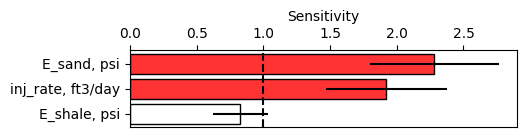

In [63]:
from pyDGSA.plot import vert_pareto_plot

fig, ax = vert_pareto_plot(mean_sensitivity, np_plot='+1', confidence=True)

It's also possible to create a pareto plot of cluster-specific sensitivities, using pre-defined colors for each cluster. Defining the colors is useful for keeping cluster colors consistent across multiple plots

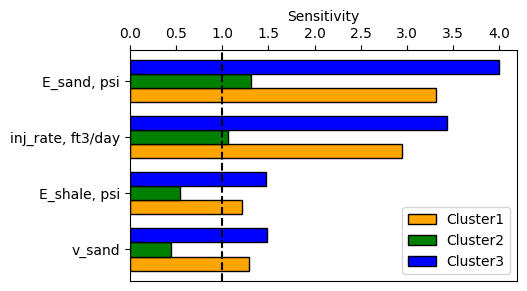

In [64]:
# Define the colors for each cluster
cluster_colors = ['orange', 'green', 'blue', 'red', 'black']

# Only plot 3 parameters total to save space (np_plot=3)
fig, ax = vert_pareto_plot(cluster_sensitivity, np_plot=4, fmt='cluster_avg', 
                           colors=cluster_colors)

Next, plot the cdf for parameter `z`, using the same color scheme as the pareto plot above.

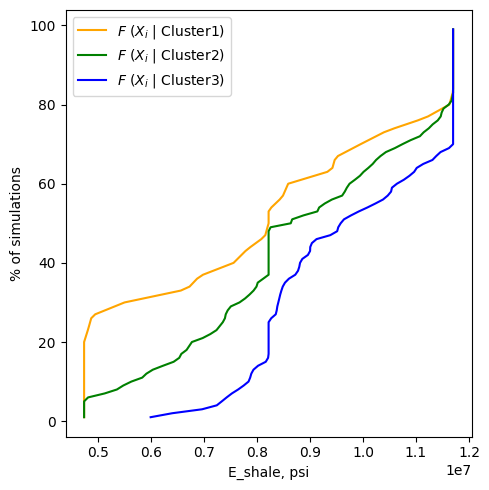

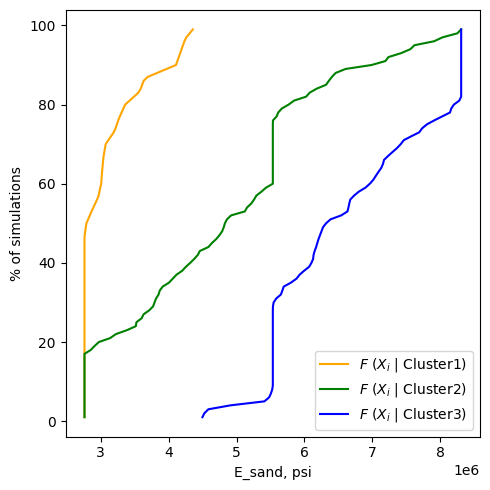

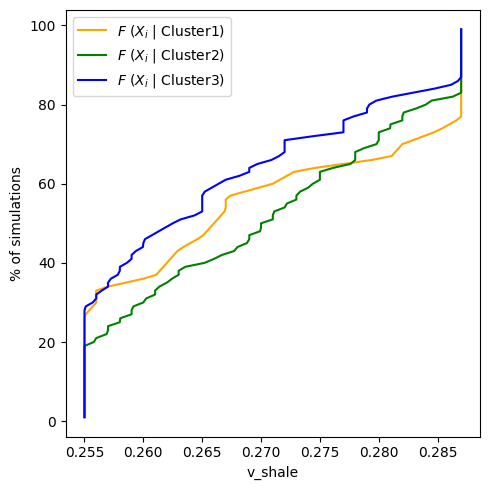

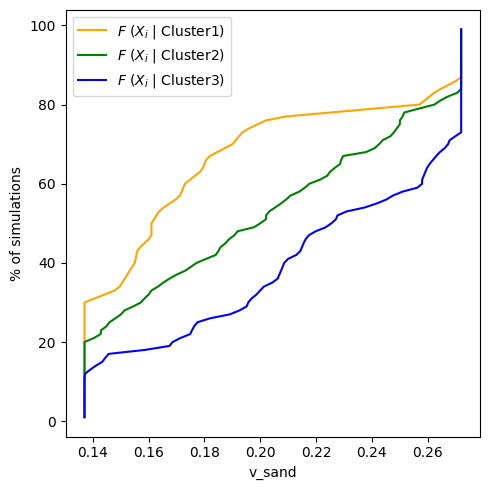

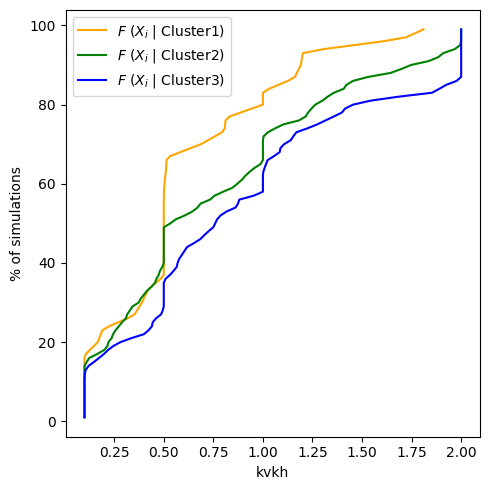

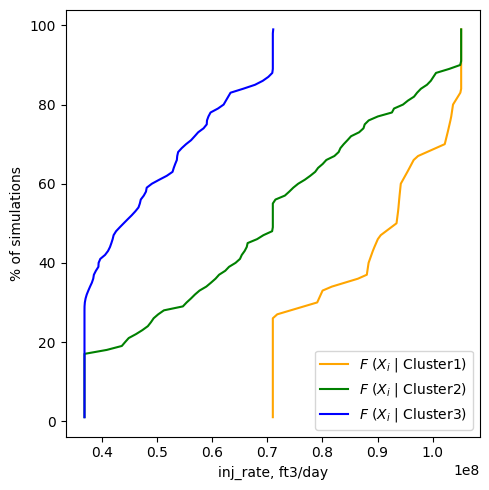

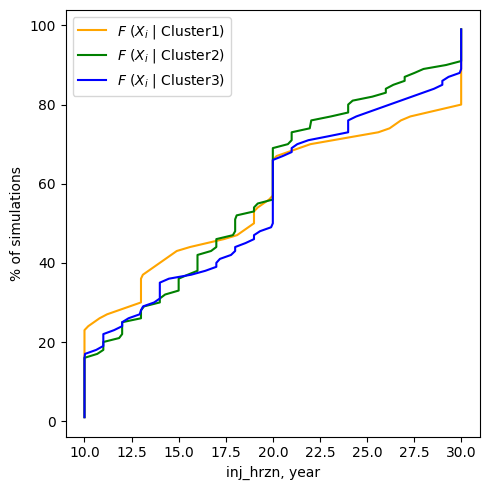

In [65]:
from pyDGSA.plot import plot_cdf

for item in parameter_names:
    fig, ax = plot_cdf(parameters, labels, item, parameter_names=parameter_names, 
                    cluster_names=cluster_names, colors=cluster_colors)

### Plotting response clusters

Next, let's plot the distance between simulations using multidimensional scaling.
This is important, as these distances are the defining feature that control all
other sensitivity calculations.

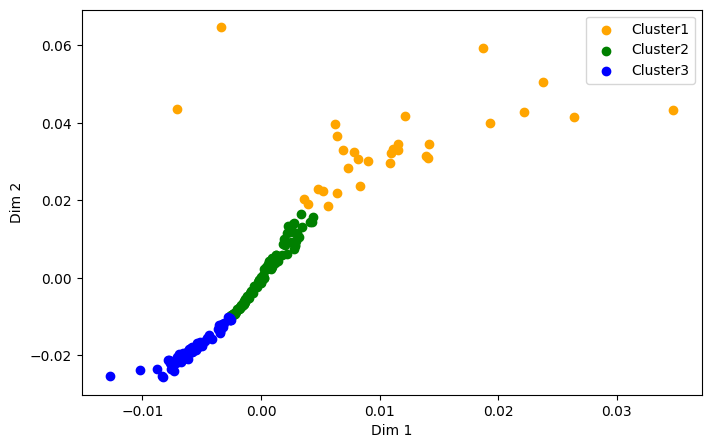

In [66]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Get MDS representation of distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress=False)
mds_dist = mds.fit_transform(distances)

## Plot mds distances as scatterplot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
x = mds_dist[:, 0]
y = mds_dist[:, 1]

# Plotting each cluster individually using a for loop,
# though it's possible to plot all clusters at once using
# ax.scatter(x, y, c=[cluster_colors[i] for i in labels])
for i in range(n_clusters):
    sc = ax.scatter(x[labels == i], y[labels == i],
                    c=cluster_colors[i], label=cluster_names[i])
ax.set(xlabel='Dim 1', ylabel='Dim 2')
ax.legend()

### Plotting `dgsa_interactions` results

To display pareto plots of two-way parameter interactions averaged across each cluster and each bin, the options are the same as when plotting `dgsa` results

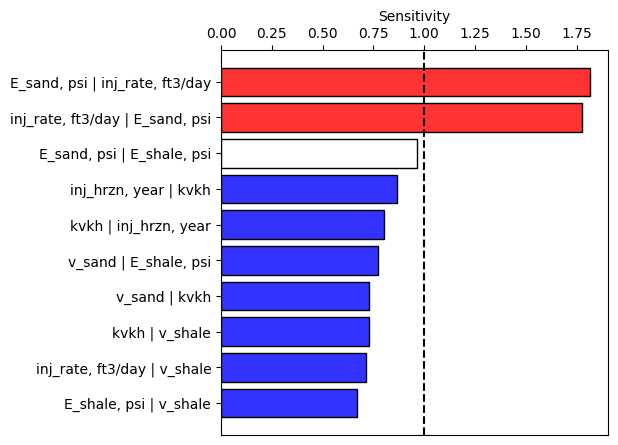

In [67]:
# Only show interactions with sensitivity >= 1 and the next 5 most 
# sensitive interactions (np_plot = '+8')
fig, ax = vert_pareto_plot(mean_interact_sensitivity, np_plot='+8')

Similarly, the options when cluster-specific `dgsa_interactions` results is the same as when plotting cluster-specific `dgsa` results.

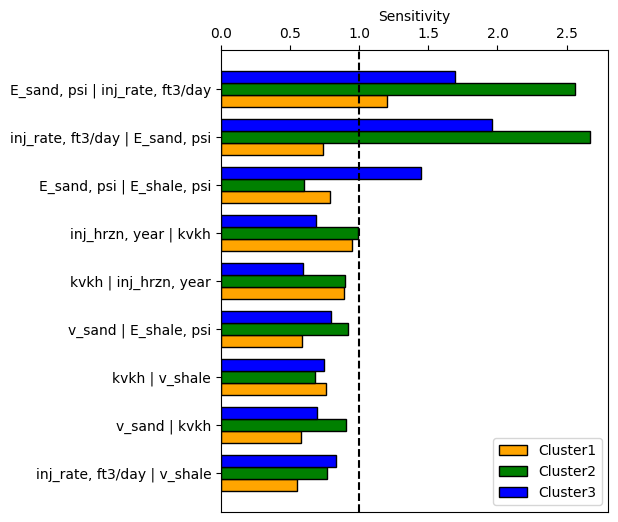

In [68]:
# By default, np_plot = '+5'
fig, ax = vert_pareto_plot(cluster_interact_sensitivity, 
                           fmt='cluster_avg',
                           colors=cluster_colors)

Plot the standardized sensitivity for each bin/cluster combination is also possible. Note that the bars with a bold outline represent those for which the sensitivity >= 1.

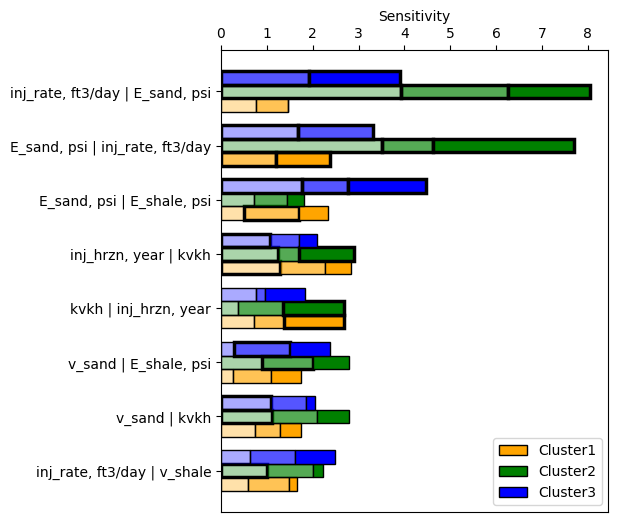

In [69]:
fig, ax = vert_pareto_plot(raw_interact_sensitivity, 
                           fmt='indiv',
                           colors=cluster_colors,
                           np_plot=8)